[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/dustpy/HEAD?labpath=examples%2F6_dust_evolution.ipynb)

# 6. Dust Evolution

Dust evolution in `DustPy` consists of three parts: coagulation, hydrodynamics, and external sources.  
Their source terms are stored in `Simulation.dust.S`.

In [1]:
from dustpy import Simulation
sim = Simulation()
sim.ini.grid.Nr = 5
sim.ini.grid.mmax = 10. * sim.ini.grid.mmin
sim.ini.dust.allowDriftingParticles = True
sim.initialize()

The dust is by default integrated with an implicit 1st-order Euler method.

In [2]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver),
 Instruction (Gas: implicit 1st-order direct solver)]

The implicit matrix equation that is solved for dust evolution is given by

$\frac{\vec{\Sigma}_\mathrm{d}^{n+1}-\vec{\Sigma}_\mathrm{d}^{n}}{\Delta t} = \mathbb{J} \cdot \vec{\Sigma}_\mathrm{d}^{n+1} + \vec{S}_\mathrm{ext},$

which can be written as

$\begin{split}
\left( \mathbb{1} - \Delta t\, \mathbb{J} \right) \cdot \vec{\Sigma}_\mathrm{d}^{n+1} &= \vec{\Sigma}_\mathrm{d}^{n} + \Delta t\, \vec{S}_\mathrm{ext}\\
&\equiv \vec{R}^n,
\end{split}$

with

$\vec{R}^n = \vec{\Sigma}_\mathrm{d}^{n} + \Delta t\, \vec{S}_\mathrm{ext}$.

The Jacobian $\mathbb{J}$ is a sparse matrix. $\vec{\Sigma}_\mathrm{d}$ is a one-dimensional state vector that can be produces from the surface densities with the `.ravel()` method.

In [3]:
sim.dust.Sigma.ravel().shape

(40,)

The Jacobian looks as follows.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

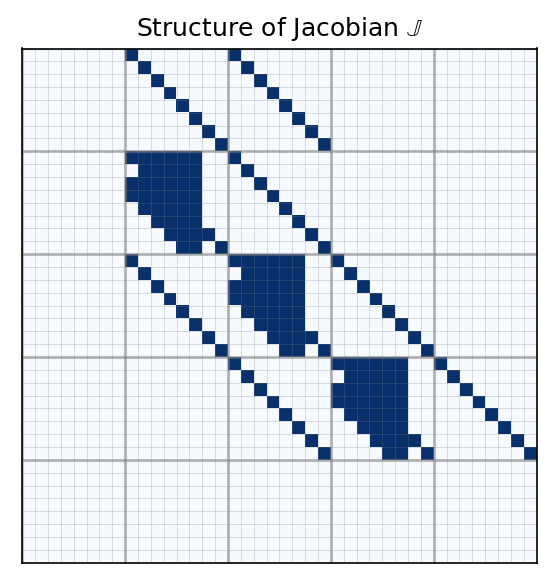

In [5]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.imshow(np.where(sim.dust.Sigma.jacobian().toarray() != 0., 1., 0.), cmap="Blues")
ax.hlines(np.arange(0., sim.grid.Nr*sim.grid.Nm, sim.grid.Nm)-0.5, -0.5, sim.grid.Nr*sim.grid.Nm-0.5, color="gray", alpha=0.5)
ax.vlines(np.arange(0., sim.grid.Nr*sim.grid.Nm, sim.grid.Nm)-0.5, -0.5, sim.grid.Nr*sim.grid.Nm-0.5, color="gray", alpha=0.5)
ax.hlines(np.arange(0., sim.grid.Nr*sim.grid.Nm, 1)-0.5, -0.5, sim.grid.Nr*sim.grid.Nm-0.5, color="gray", alpha=0.25, lw=0.5)
ax.vlines(np.arange(0., sim.grid.Nr*sim.grid.Nm, 1)-0.5, -0.5, sim.grid.Nr*sim.grid.Nm-0.5, color="gray", alpha=0.25, lw=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Structure of Jacobian $\mathbb{J}$")
fig.tight_layout()
plt.show()

This is a the Jacobian for a simulation with 5 radial grid cells and 8 mass bins. This Jacobian acts on the raveled dust surface densities `Simulation.dust.Sigma.ravel()` and has a shape of `(Simulation.grid.Nr*Simulation.grid.Nm, Simulation.grid.Nr*Simulation.grid.Nm)`

Each box has a shape `(Simulation.grid.Nm, Simulation.grid.Nm)`. The boxes on the diagonals contain the coagulation part of the Jacobian. Due to our choice of quantities shown in the chapter about coagulation, the coagulation Jacobian is an upper diagonal matrix with a limited number of lower diagonals. That number depends on the mass grid. The last two columns are empty in this case, because in this case no possible sticking collision involving the two largest mass bins exists that would results in a particle with mass smaller than the largest mass bin. Fragmentation is not happening this early in the simulation, because the relative collision velocities are not large enough.

We do not calculate coagulation in the first and last grid cells. Hence the empty boxes.

The diagonals represent the transport part of dust evolution.

The first and the last row set the boundary conditions. The inner boundary is set to constant gradient. Therefore, the second and third boxes of the first row have diagonals. The outer boundary is set to floor value. Therefore the entire row is empty.

Since most of the elements of the Jacobian are empty – especially in larger simulations – the Jacobians is stored as sparse matrix only saving the non-zero elements.

The implicit integration schemes that come with `simframe` only integrates equations of kind

$\left( \mathbb{1} - \Delta t\, \mathbb{J} \right) \cdot \vec{Y}^{n+1} = \vec{Y}^n$.

We have therefore created a custom integration schemes for our needs.  
Whenever `Simulation.dust.Sigma.jacobian()` is called, the right-hand side of our equation is calculated and stored in a hidden field `Simulation.dusts._rhs`, that can be accessed by our integration scheme.

The first and the last rows of the Jacobian, which contain the boundary conditions do not contain the time step $\Delta t$, since this is not necessarily known when calculating the Jacobian. The integration scheme will add the terms containing the time step.

The custom integration scheme can be found in `dustpy.std.dust.impl_1_direct`.

## Coagulation

Please see the previous chapter for details on coagulation.  
The coagulation source terms are stored in `Simulation.dust.S.coag`.

### Turning off Fragmentation

If you want to turn off fragmentation (but not sticking), set the sticking probabilities to $1$, the fragmentation probabilities to $0$, and unset the updater of the probabilities.

In [6]:
sim.dust.p.stick = 1.
sim.dust.p.frag = 0.
sim.dust.p.updater = None

**Note:** You could also set the fragmentation velocities to a very large value that will never be reached. However, this will still calculate the probabilies at every timestep, even though they are constant in this case and consume valuable computational resources.

### Turning off Coagulation

If you want to turn off coagulation in total, you have to set both probabilities to zero.

In [7]:
sim.dust.p.stick = 0.
sim.dust.p.frag = 0.
sim.dust.p.updater = None

You can furthermore unset the updaters of the other fields, that are only used for coagulation to save computational resources.

In [8]:
sim.dust.p.updater = None
sim.dust.v.rel.updater = None
sim.dust.v.frag.updater = None
sim.dust.kernel.updater = None

## Hydrodynamics

`DustPy` solves the following equation for dust transport

$\frac{\partial}{\partial t} \Sigma_\mathrm{d} + \frac{1}{r} \frac{\partial}{\partial r} \left( r\Sigma_\mathrm{d}v_\mathrm{rad} \right) - \frac{1}{r} \frac{\partial}{\partial r} \left[ r D \Sigma_\mathrm{g} \frac{\partial}{\partial r} \left( \frac{\Sigma_\mathrm{d}}{\Sigma_\mathrm{g}} \right) \right] = 0$

The dust hydrodynamics consists of an advective and an diffusive term. The algorithm calculates the advective and diffusive fluxes separately at the grid cell interfaces. Furthermore, the sum of both is calculated.

In [9]:
sim.dust.Fi

Group (Fluxes)
--------------
    adv          : Field (Advective flux [g/cm/s])
    diff         : Field (Diffusive flux [g/cm/s])
    tot          : Field (Total flux [g/cm/s])
  -----

### Advection

The advective fluxes at the grid interfaces are calculated as

$F_\mathrm{adv} = v_\mathrm{rad} \cdot \Sigma_\mathrm{d}$

and interpolated onto the grid cell interfaces. The default boundary condition assumes constant velocity.

### Turning off Advection

To turn off advection, you can set the radial dust velocities to $0$ and unset the updater.

In [10]:
sim.dust.v.rad = 0
sim.dust.v.rad.updater = None

You might also want to unset the relative velocities caused by azimuthal drift.  
If you have set a backreaction mechanism you may need to unset it, too, for your model.

### Diffusion

The diffusive fluxes are given by

$F_\mathrm{diff} = -D\Sigma_\mathrm{g}\nabla\frac{\Sigma_\mathrm{d}}{\Sigma_\mathrm{gas}}$

A flux limiter limits the maximum diffusive flux to the diffusive RMS velocity of that dust species. The diffusive flux through the boundaries is set to zero.

### Turning off Diffusion

To turn off dust diffusion you can set the diffusivities to $0$ and unset the updater.

In [11]:
sim.dust.D = 0.
sim.dust.D.updater = None

### Turning off Hydrodynamics

If you want to turn off dust hydrodynamics in total, you have to set the radial dust velocity and the dust diffusivities to $0$.

In [12]:
sim.dust.v.rad = 0.
sim.dust.v.rad.updater = None
sim.dust.D = 0.
sim.dust.D.updater = None

Depending on the aim of your simulation, you can unset the updaters of other fields, if you don't need them.

## External Sources

`DustPy` has the possibility to add external source/loss terms that you can set. With those you can for example add dust in case of infall or remove dust in case of planetesimal formation or pebble accretion.

By default the external sources are $0$ without a set updater.

## Turning off Dust Evolution

If you want to deactivate dust evolution as a whole you can remove the integration instruction from the instruction set.

In [13]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver),
 Instruction (Gas: implicit 1st-order direct solver)]

In [14]:
del(sim.integrator.instructions[0])

In [15]:
sim.integrator.instructions

[Instruction (Gas: implicit 1st-order direct solver)]

You can also deactivate other fields, that are not needed in that case, as described above.

Keep in mind that the updaters of all fields within `Simulation.dust` will still be called and the fields will be updated unless their updaters are unset. This will on one hand cost computational ressources, and on the other hand could influence the physics in an unwanted way.

For example the dust backreaction coefficients will still be calculated and can have an effect on the gas, even though the dust is in principle not moving.

Always keep in mind what you want to achieve by turning off dust evolution and unset the updaters of certain fields, if required.

## Changing the Dust Integrator

By default the dust surface densities are integrated implicitly. This involves a matrix inversion. In some cases if the matrix is weakly conditioned this can cause a violation of mass conservation. In that case you might want to use an explicit integrator instead. You can do this by calling

In [16]:
sim.setdustintegrator(scheme="explicit", method="cash-karp")

Setting dust integrator
    scheme: explicit
    method: cash-karp


to set the dust integrator to an explicit 5th-order scheme. The function also changes the update order automatically, since for explicit integration all quantities need to be updated before integration. The update order for explicit integration is

In [17]:
sim.dust.updater = ["delta", "rhos", "fill", "a", "St", "H", "rho", "backreaction", "v", "D", "eps", "Fi", "kernel", "p", "S"]
sim.dust.backreaction.updater = ["A", "B"]
sim.dust.delta.updater = ["rad", "turb", "vert"]
sim.dust.Fi.updater = ["adv", "diff", "tot"]
sim.dust.p.updater = ["frag", "stick"]
sim.dust.S.updater = ["coag", "hyd", "ext", "tot"]
sim.dust.v.updater = ["frag", "driftmax", "rad", "rel"]
sim.dust.v.rel.updater = ["azi", "brown", "rad", "turb", "vert", "tot"]

There are other options for setting the dust integrator. See

In [18]:
help(sim.setdustintegrator)

Help on method setdustintegrator in module dustpy.simulation:

setdustintegrator(scheme='explicit', method='cash-karp') method of dustpy.simulation.Simulation instance
    Function sets the dust integrator.
    
    Parameters
    ----------
    scheme : string, optional, default : "explicit"
        Possible values
            {"explicit", "implicit"}
    method : string, optional, default : "cash-karp"
        Possible values for explicit integration
            {"cash-karp"}
        Possible values for implicit integration
            {"direct", "gmres", "bicgstab}

